# Jewellery Price Optimization with ML: Pricing Data to Refine Pricing Strategies

# 1. Business Understanding
Inconsistent pricing strategies across regions and product lines.
Lack of a data-driven approach to predict demand elasticity.
High competition necessitating quick responses to market trend


# Imprt Libraires

In [1]:
# Essential Configuration
%matplotlib inline
%config InlineBackend.figure_formats = {'retina', 'svg'}

# Core Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from matplotlib import colors as mcolors
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)


# Scikit-learn Libraries

from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline


# Display Settings
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Adjust the display width to accommodate all columns

# Seaborn Default Settings
sns.set(
    {
        "figure.figsize": (8, 6)
    },
    style='ticks',
    color_codes=True,
    font_scale=0.8
)

# mlflow
import mlflow
import mlflow.sklearn
import mlflow.xgboost

# other libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import skew
from category_encoders import TargetEncoder
from phik import phik_matrix
import xgboost as xgb
import category_encoders as ce



# 1.0 Data Understanding and Exploratory Data Analysis (EDA)
# 1.1 Load Dataset and Add Column Headers


In [2]:
# Load dataset
df = pd.read_csv('Jewelry_Dataset.csv')

# Add column headers
df.columns = [
    "Order_datetime",
    "Order_ID",
    "Product_ID",
    "SKU_Quantity",
    "Category_ID",
    "Category",
    "Brand_ID",
    "Price_USD",
    "User_ID",
    "Target_Gender",
    "Main_Color",
    "Main_Metal",
    "Main_Gem"
]

# Display first five rows
df.head()


Order_datetime             Order_ID           Product_ID  \
0  2018-12-01 17:38:31 UTC  1924899396621697920  1806829193678291446   
1  2018-12-02 13:53:42 UTC  1925511016616034733  1842214461889315556   
2  2018-12-02 17:44:02 UTC  1925626951238681511  1835566849434059453   
3  2018-12-02 21:30:19 UTC  1925740842841014667  1873936840742928865   
4  2018-12-02 22:09:34 UTC  1925760595336888995  1835566854827934449   

   SKU_Quantity   Category_ID          Category  Brand_ID  Price_USD  \
0             1  1.806829e+18               NaN       NaN     212.14   
1             1  1.806829e+18   jewelry.pendant       1.0      54.66   
2             1  1.806829e+18   jewelry.pendant       0.0      88.90   
3             1  1.806829e+18  jewelry.necklace       0.0     417.67   
4             1  1.806829e+18   jewelry.earring       1.0     102.27   

        User_ID Target_Gender Main_Color Main_Metal  Main_Gem  
0  1.515916e+18           NaN     yellow       gold       NaN  
1  1.515916e+18             f      white       gold  sapphire  
2  1.515916e+18             f        red       gold   diamond  
3  1.515916e+18           NaN        red       gold  amethyst  
4  1.515916e+18           NaN        red       gold       NaN

# Data Description

The features contained in the dataset are:
1. Order datetime: The time at which the order was placed.
2. Order ID: Identifiers for the different orders placed.
3. Purchased product ID: Identifiers for the different product ordered for.
4. Quantity of SKU in the order: Quantity of jewelry pieces ordered for.
5. Category ID: Identifier for the jewelry category.
6. Category alias: Name of jewelry category e.g. earring.
7. Brand ID: Identifier for jeweler brand
8. Price in USD: Jewelry price in US Dollars
9. User ID: Identifier for user/customer
10. Product gender (for male/female) (Target gender for jewelry piece)
11. Main Color: Overall color of jewelry piece
12. Main metal: Main metal used for mounting
13. Main gem: Main gem mounted on jewelry piece


# 1.2 Dataset Summary

In [3]:
# Check dataset shape
print(f"The Dataset shape is: {df.shape}")

print("----------------------------------")

# Dataset info
df.info()


The Dataset shape is: (95910, 13)
----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95910 entries, 0 to 95909
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order_datetime  95910 non-null  object 
 1   Order_ID        95910 non-null  int64  
 2   Product_ID      95910 non-null  int64  
 3   SKU_Quantity    95910 non-null  int64  
 4   Category_ID     90558 non-null  float64
 5   Category        85977 non-null  object 
 6   Brand_ID        91125 non-null  float64
 7   Price_USD       90558 non-null  float64
 8   User_ID         90558 non-null  float64
 9   Target_Gender   47743 non-null  object 
 10  Main_Color      88250 non-null  object 
 11  Main_Metal      90448 non-null  object 
 12  Main_Gem        61852 non-null  object 
dtypes: float64(4), int64(3), object(6)
memory usage: 9.5+ MB


In [4]:
# Check for missing values and percentage of missing values
missing_values = df.isnull().sum()
missing_percentage = 100 * df.isnull().sum() / len(df)

# Combine the results into a single DataFrame for better readability
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print("Missing Value Description:")
print(missing_summary)


Missing Value Description:
                Missing Values  Percentage
Order_datetime               0    0.000000
Order_ID                     0    0.000000
Product_ID                   0    0.000000
SKU_Quantity                 0    0.000000
Category_ID               5352    5.580231
Category                  9933   10.356584
Brand_ID                  4785    4.989052
Price_USD                 5352    5.580231
User_ID                   5352    5.580231
Target_Gender            48167   50.221041
Main_Color                7660    7.986654
Main_Metal                5462    5.694922
Main_Gem                 34058   35.510374


In [5]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

print("---------------------------------------")

# Check unique values
print(f"Unique values:\n{df.nunique()}")


The dataset contains 2589 duplicate rows that need to be removed.
---------------------------------------
Unique values:
Order_datetime    74504
Order_ID          74759
Product_ID         9613
SKU_Quantity          1
Category_ID          25
Category            218
Brand_ID           2537
Price_USD          3166
User_ID           31079
Target_Gender         2
Main_Color            5
Main_Metal            3
Main_Gem             30
dtype: int64


In [6]:
# Create a DataFrame with counts and percentages -Target Gender Distribution
gender_distribution = pd.DataFrame({
    'Count': df['Target_Gender'].value_counts(),
    'Percentage (%)': df['Target_Gender'].value_counts(normalize=True) * 100
}).reset_index()

# Rename columns for clarity
gender_distribution.columns = ['Target Gender', 'Count', 'Percentage (%)']

# Display the DataFrame
gender_distribution


Target Gender  Count  Percentage (%)
0             f  47379       99.237585
1             m    364        0.762415

In [7]:
# Check unique values for categorical features
print("Unique Values in Categorical Features:")
print("---------------------------------------")
print(f"1. Target Gender: {df['Target_Gender'].unique()}")
print("---------------------------------------")
print(f"2. Main Color: {df['Main_Color'].unique()}")
print("---------------------------------------")
print(f"3. Main Metal: {df['Main_Metal'].unique()}")
print("---------------------------------------")
print(f"4. Main Gem: {df['Main_Gem'].unique()}")
print("---------------------------------------")
print(f"5. Category: {df['Category'].unique()}")


Unique Values in Categorical Features:
---------------------------------------
1. Target Gender: [nan 'f' 'm']
---------------------------------------
2. Main Color: ['yellow' 'white' 'red' nan 'unknown-color' 'black']
---------------------------------------
3. Main Metal: ['gold' 'silver' nan 'platinum']
---------------------------------------
4. Main Gem: [nan 'sapphire' 'diamond' 'amethyst' 'fianit' 'pearl' 'quartz' 'topaz'
 'garnet' 'quartz_smoky' 'ruby' 'agate' 'mix' 'citrine' 'emerald' 'amber'
 'chrysolite' 'chrysoprase' 'nanocrystal' 'turquoise' 'sitall'
 'corundum_synthetic' 'coral' 'onyx' 'nacre' 'spinel' 'tourmaline'
 'emerald_geothermal' 'garnet_synthetic' 'rhodolite' 'sapphire_geothermal']
---------------------------------------
5. Category: [nan 'jewelry.pendant' 'jewelry.necklace' 'jewelry.earring' 'jewelry.ring'
 'jewelry.brooch' 'jewelry.bracelet' 'electronics.clocks'
 'jewelry.souvenir' '230.12' '202.36' '1098.03' '321.78' '1128.62' '81.27'
 '34.25' '582.16' '227.37' '

# 1.3 Statistical Analysis

In [8]:
# Summary statistics
df.describe(include='all').round(2)

Order_datetime      Order_ID    Product_ID  SKU_Quantity  \
count                     95910  9.591000e+04  9.591000e+04       95910.0   
unique                    74504           NaN           NaN           NaN   
top     2020-10-17 12:58:28 UTC           NaN           NaN           NaN   
freq                         26           NaN           NaN           NaN   
mean                        NaN  2.485191e+18  1.815970e+18           1.0   
std                         NaN  1.934750e+17  2.136814e+17           0.0   
min                         NaN  1.924899e+18  1.313551e+18           1.0   
25%                         NaN  2.379732e+18  1.515966e+18           1.0   
50%                         NaN  2.524282e+18  1.956664e+18           1.0   
75%                         NaN  2.644347e+18  1.956664e+18           1.0   
max                         NaN  2.719022e+18  2.541962e+18           1.0   

         Category_ID         Category      Brand_ID  Price_USD       User_ID  \
count   9.055800e+04            85977  9.112500e+04   90558.00  9.055800e+04   
unique           NaN              218           NaN        NaN           NaN   
top              NaN  jewelry.earring           NaN        NaN           NaN   
freq             NaN            29051           NaN        NaN           NaN   
mean    1.805947e+18              NaN  8.891036e+16     362.21  1.512644e+18   
std     2.083954e+16              NaN  3.559651e+17     444.16  2.374776e+16   
min     1.313678e+18              NaN  0.000000e+00       0.99  1.313554e+18   
25%     1.806829e+18              NaN  0.000000e+00     145.62  1.515916e+18   
50%     1.806829e+18              NaN  1.000000e+00     258.77  1.515916e+18   
75%     1.806829e+18              NaN  1.000000e+00     431.37  1.515916e+18   
max     1.806829e+18              NaN  1.550613e+18   34448.60  1.554297e+18   

       Target_Gender Main_Color Main_Metal Main_Gem  
count          47743      88250      90448    61852  
unique             2          5          3       30  
top                f        red       gold  diamond  
freq           47379      69510      89081    29609  
mean             NaN        NaN        NaN      NaN  
std              NaN        NaN        NaN      NaN  
min              NaN        NaN        NaN      NaN  
25%              NaN        NaN        NaN      NaN  
50%              NaN        NaN        NaN      NaN  
75%              NaN        NaN        NaN      NaN  
max              NaN        NaN        NaN      NaN


# Initial observations on Data exploration:

1. Dataset Size:There are 95,9100 rows and 8 columns in the dataset. 
2. Missing Values: Nine columns exhibit missing/null values that require attention, of great concern is that of 'Target_Gender' which has over 48,000 missing rows.
3. Data Type: There are 4 floats, 3 intergers and 6 objects data types.
4. 
5. Duplicates:There are 2,589  duplicate values  identified in the dataset.
6. 
7. Variety in Categories: There are some columns with several varieties of unique values but some features exhibit low variety like 'Target_Gender ', 'SKU_Quantity', 'Main_Color', 'Main_Metal'.
8. Outliers in Price:
*   Price ranges from 0.99 to 34,448.60 requiring additional scrutiny.                                 .
9. 
10. Correction of Category Values: There are a lot of corrupt data such '451.10' '283.49' etc  in 'Category' feature that needs to be corrected.

# 1.4 Features Distribution Analysis
# 1.4.1 Price Distribution 

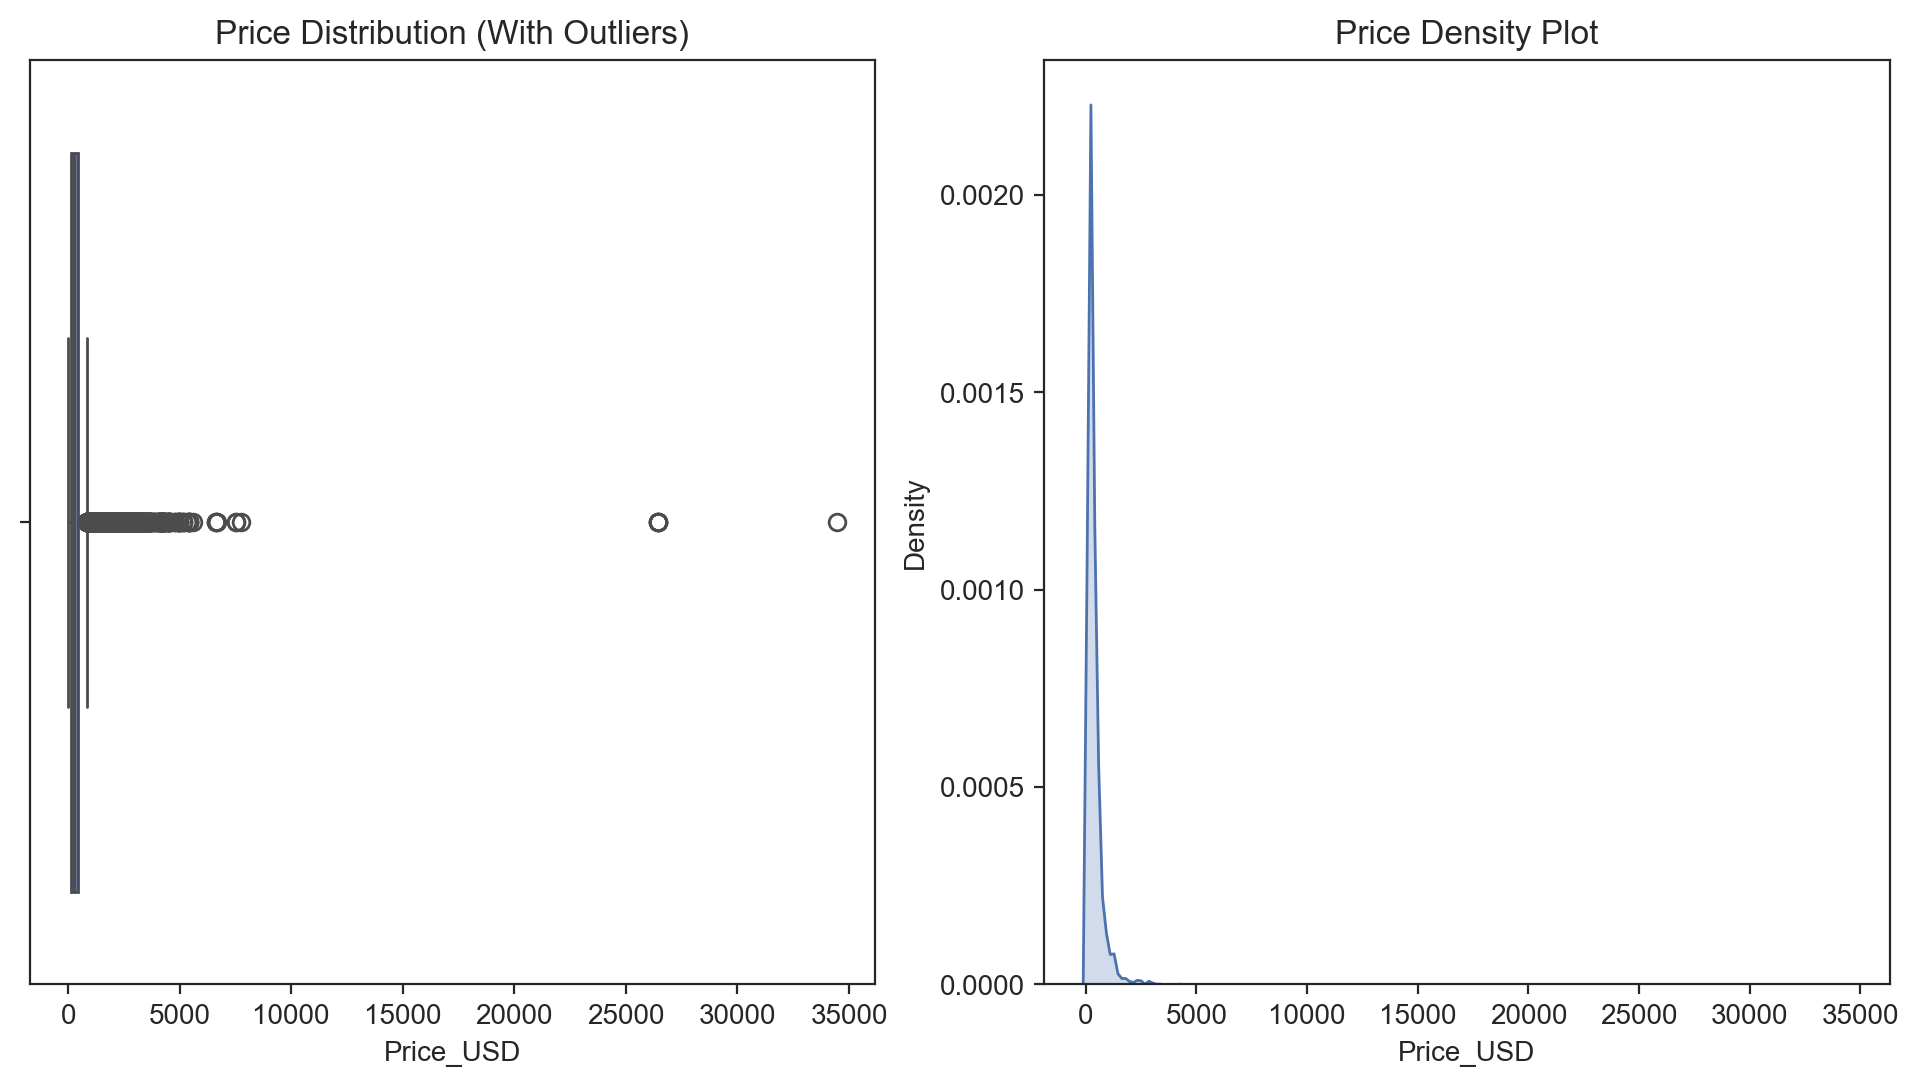

The Price skewness: 18.95906072625981
The Price kurtosis: 1054.8979068506155


In [9]:
# Distribution of Price_USD
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='Price_USD', showfliers=True)
plt.title("Price Distribution (With Outliers)")

plt.subplot(1, 2, 2)
sns.kdeplot(data=df['Price_USD'], shade=True)
plt.title("Price Density Plot")
plt.show()

# Check skewness and kurtosis of Price_USD
print(f"The Price skewness: {df['Price_USD'].skew()}")
print(f"The Price kurtosis: {df['Price_USD'].kurtosis()}")


# Comment

# 1.4.2 Univariate Analysis of Categorical Features

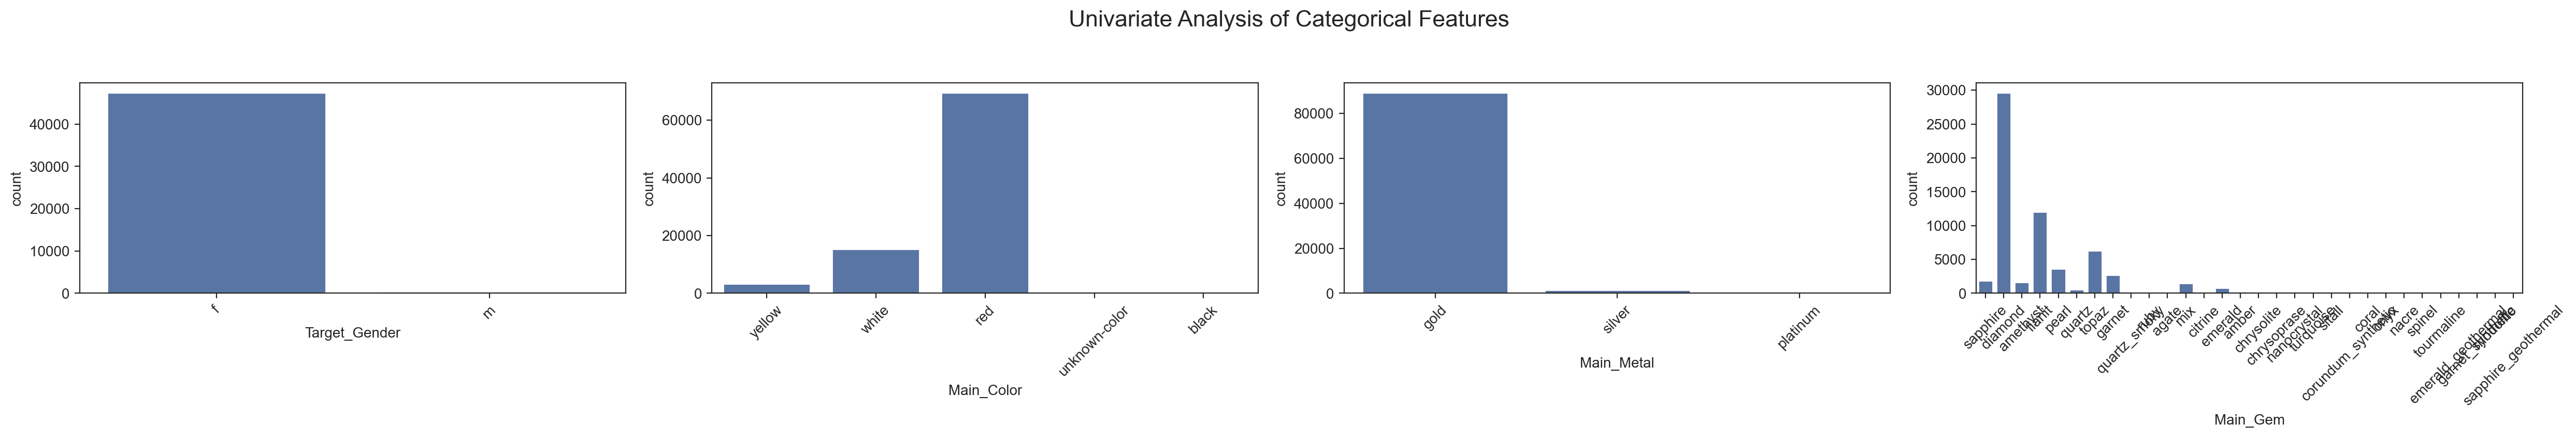

In [10]:
#Categorical features - Univaraite analysis
categorical_features = ['Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']

fig, axes = plt.subplots(1, len(categorical_features), figsize=(25, 4))
plt.suptitle("Univariate Analysis of Categorical Features", fontsize=16, y=1.05)

for i, col in enumerate(categorical_features):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# 2.0 Data Preprocessing
# 2.1 Filter Relevant Jewelry Categories

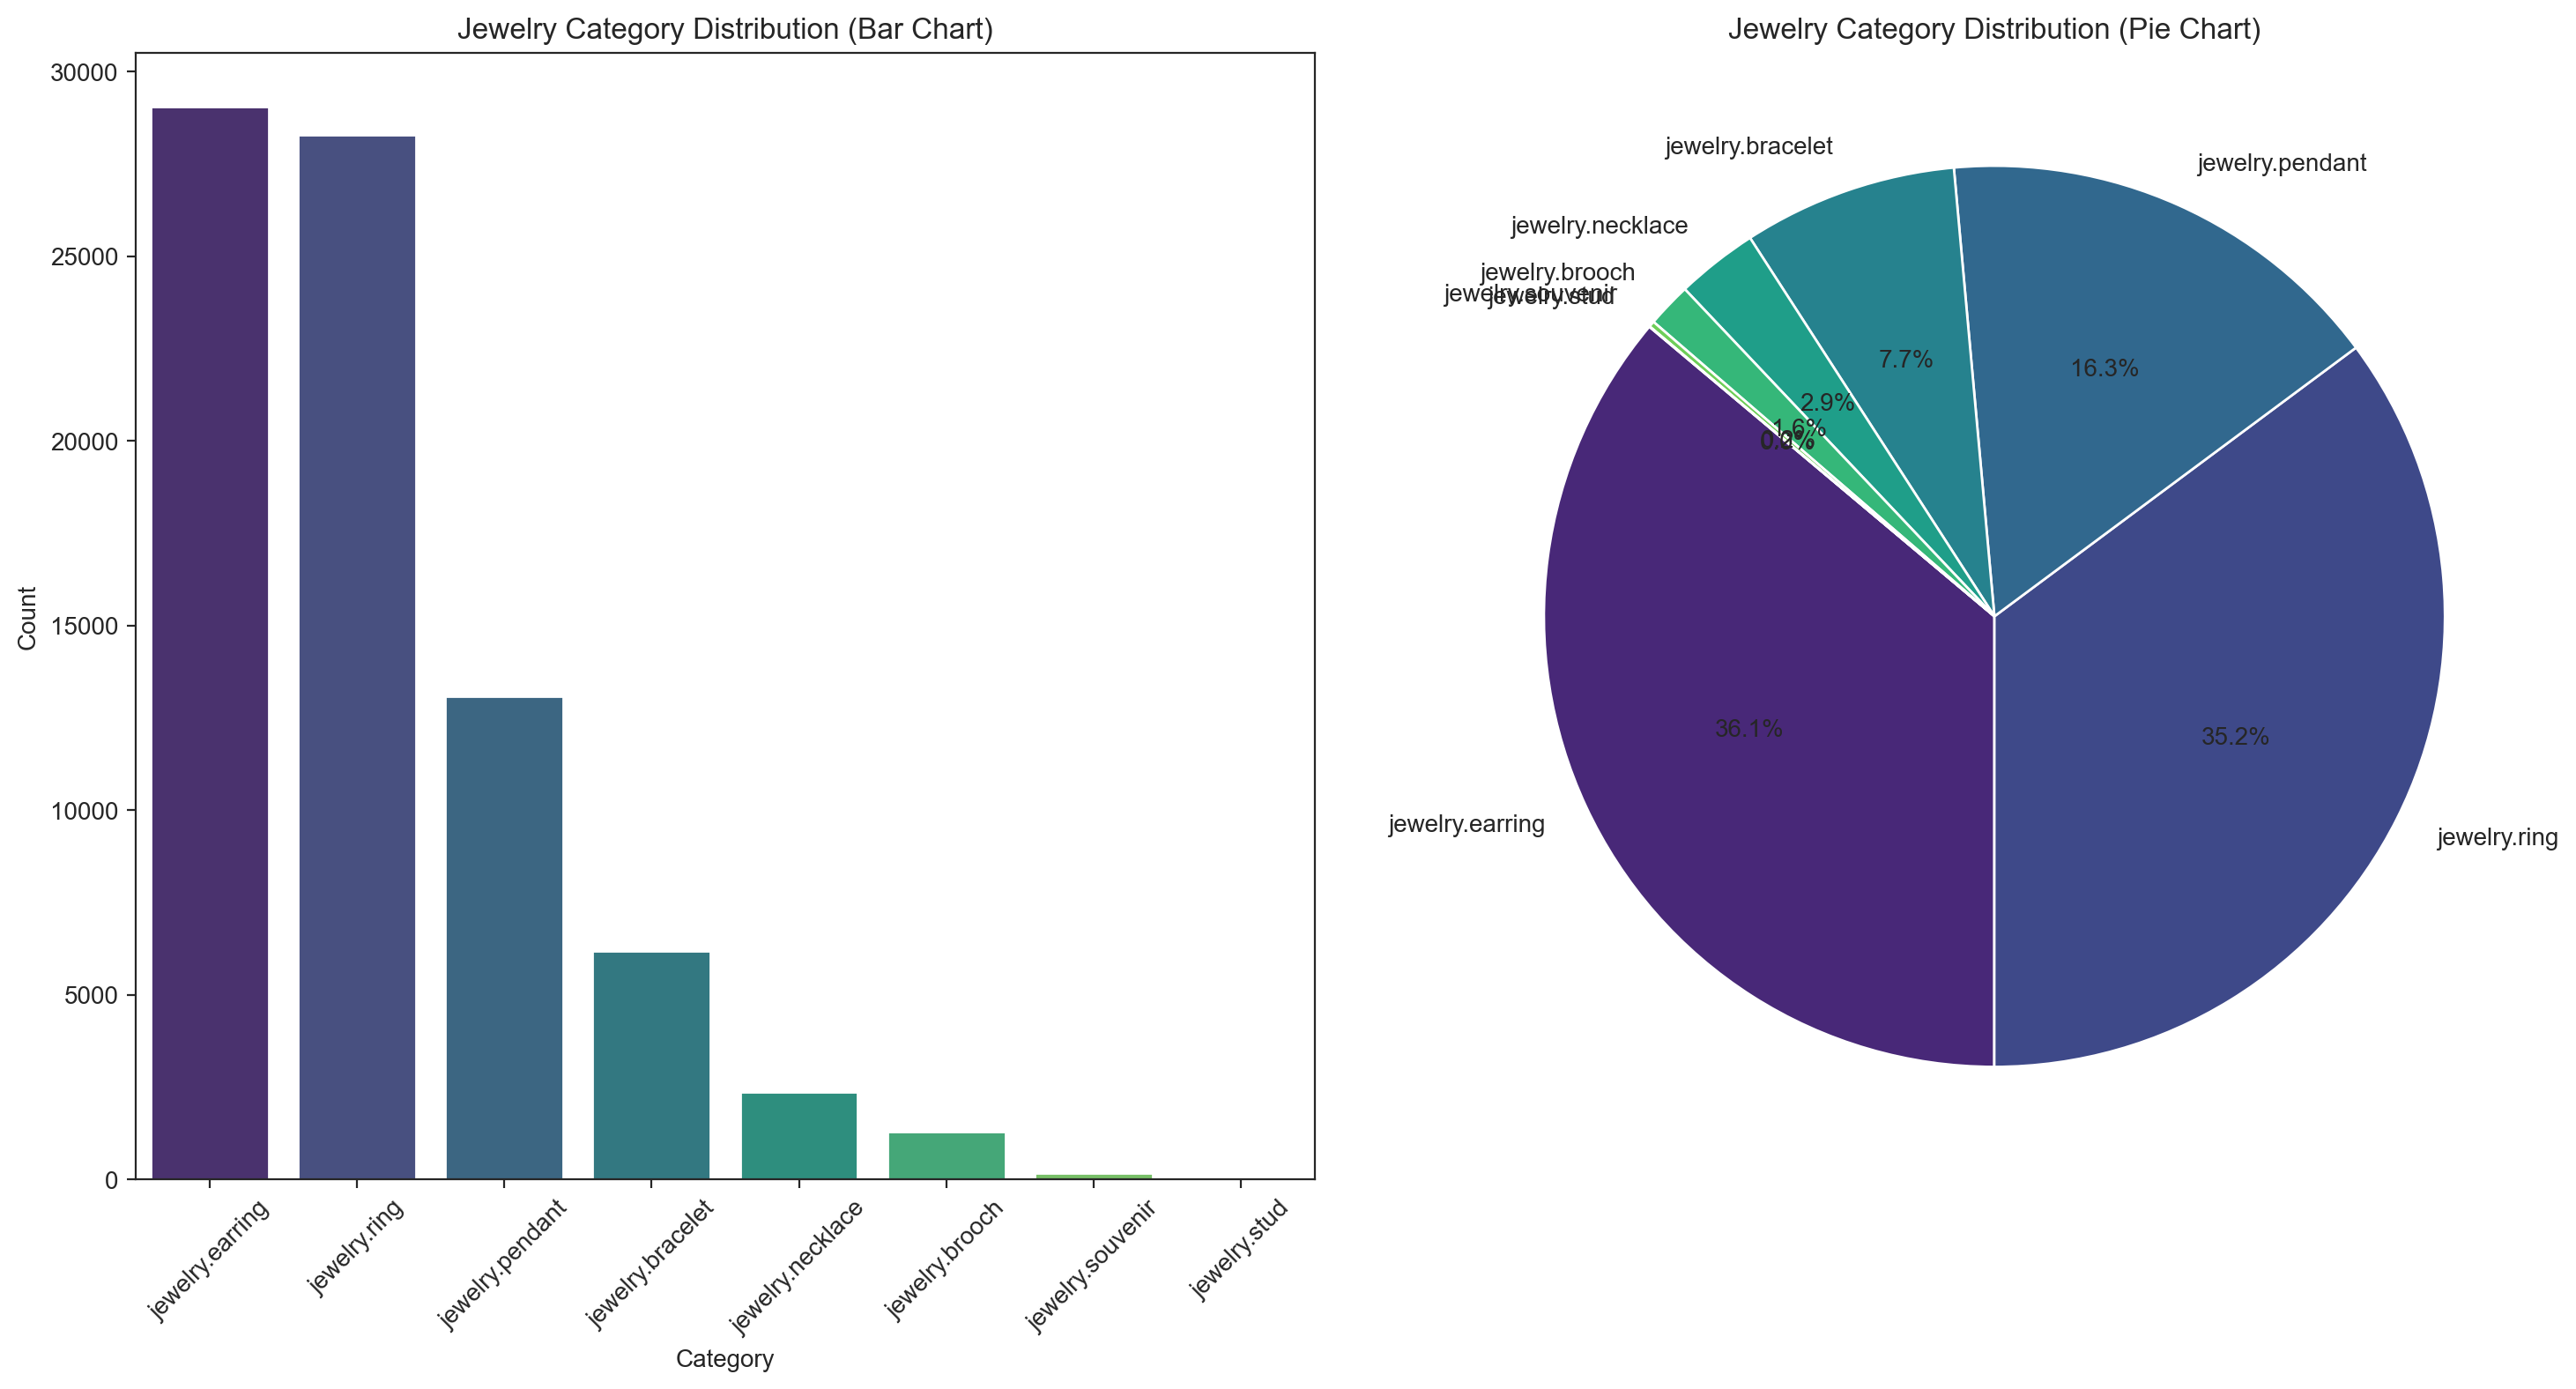

In [11]:
# Filter jewelry-related categories
jewelry_categories = [
    'jewelry.pendant', 'jewelry.necklace', 'jewelry.earring', 
    'jewelry.ring', 'jewelry.brooch', 'jewelry.bracelet',
    'jewelry.souvenir', 'jewelry.stud'
]
df_cleaned = df[df['Category'].isin(jewelry_categories)].reset_index(drop=True)

# Prepare data for visualization
category_counts = df_cleaned['Category'].value_counts()

# Create the figure and axes for side-by-side charts
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Bar chart
sns.barplot(x=category_counts.index, y=category_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title("Jewelry Category Distribution (Bar Chart)")
axes[0].set_xticklabels(category_counts.index, rotation=45)
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Count")

# Pie chart
axes[1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(category_counts)))
axes[1].set_title("Jewelry Category Distribution (Pie Chart)")

# Adjust layout
plt.tight_layout()
plt.show()


# 2.1.1 Jewelry Category by Gender


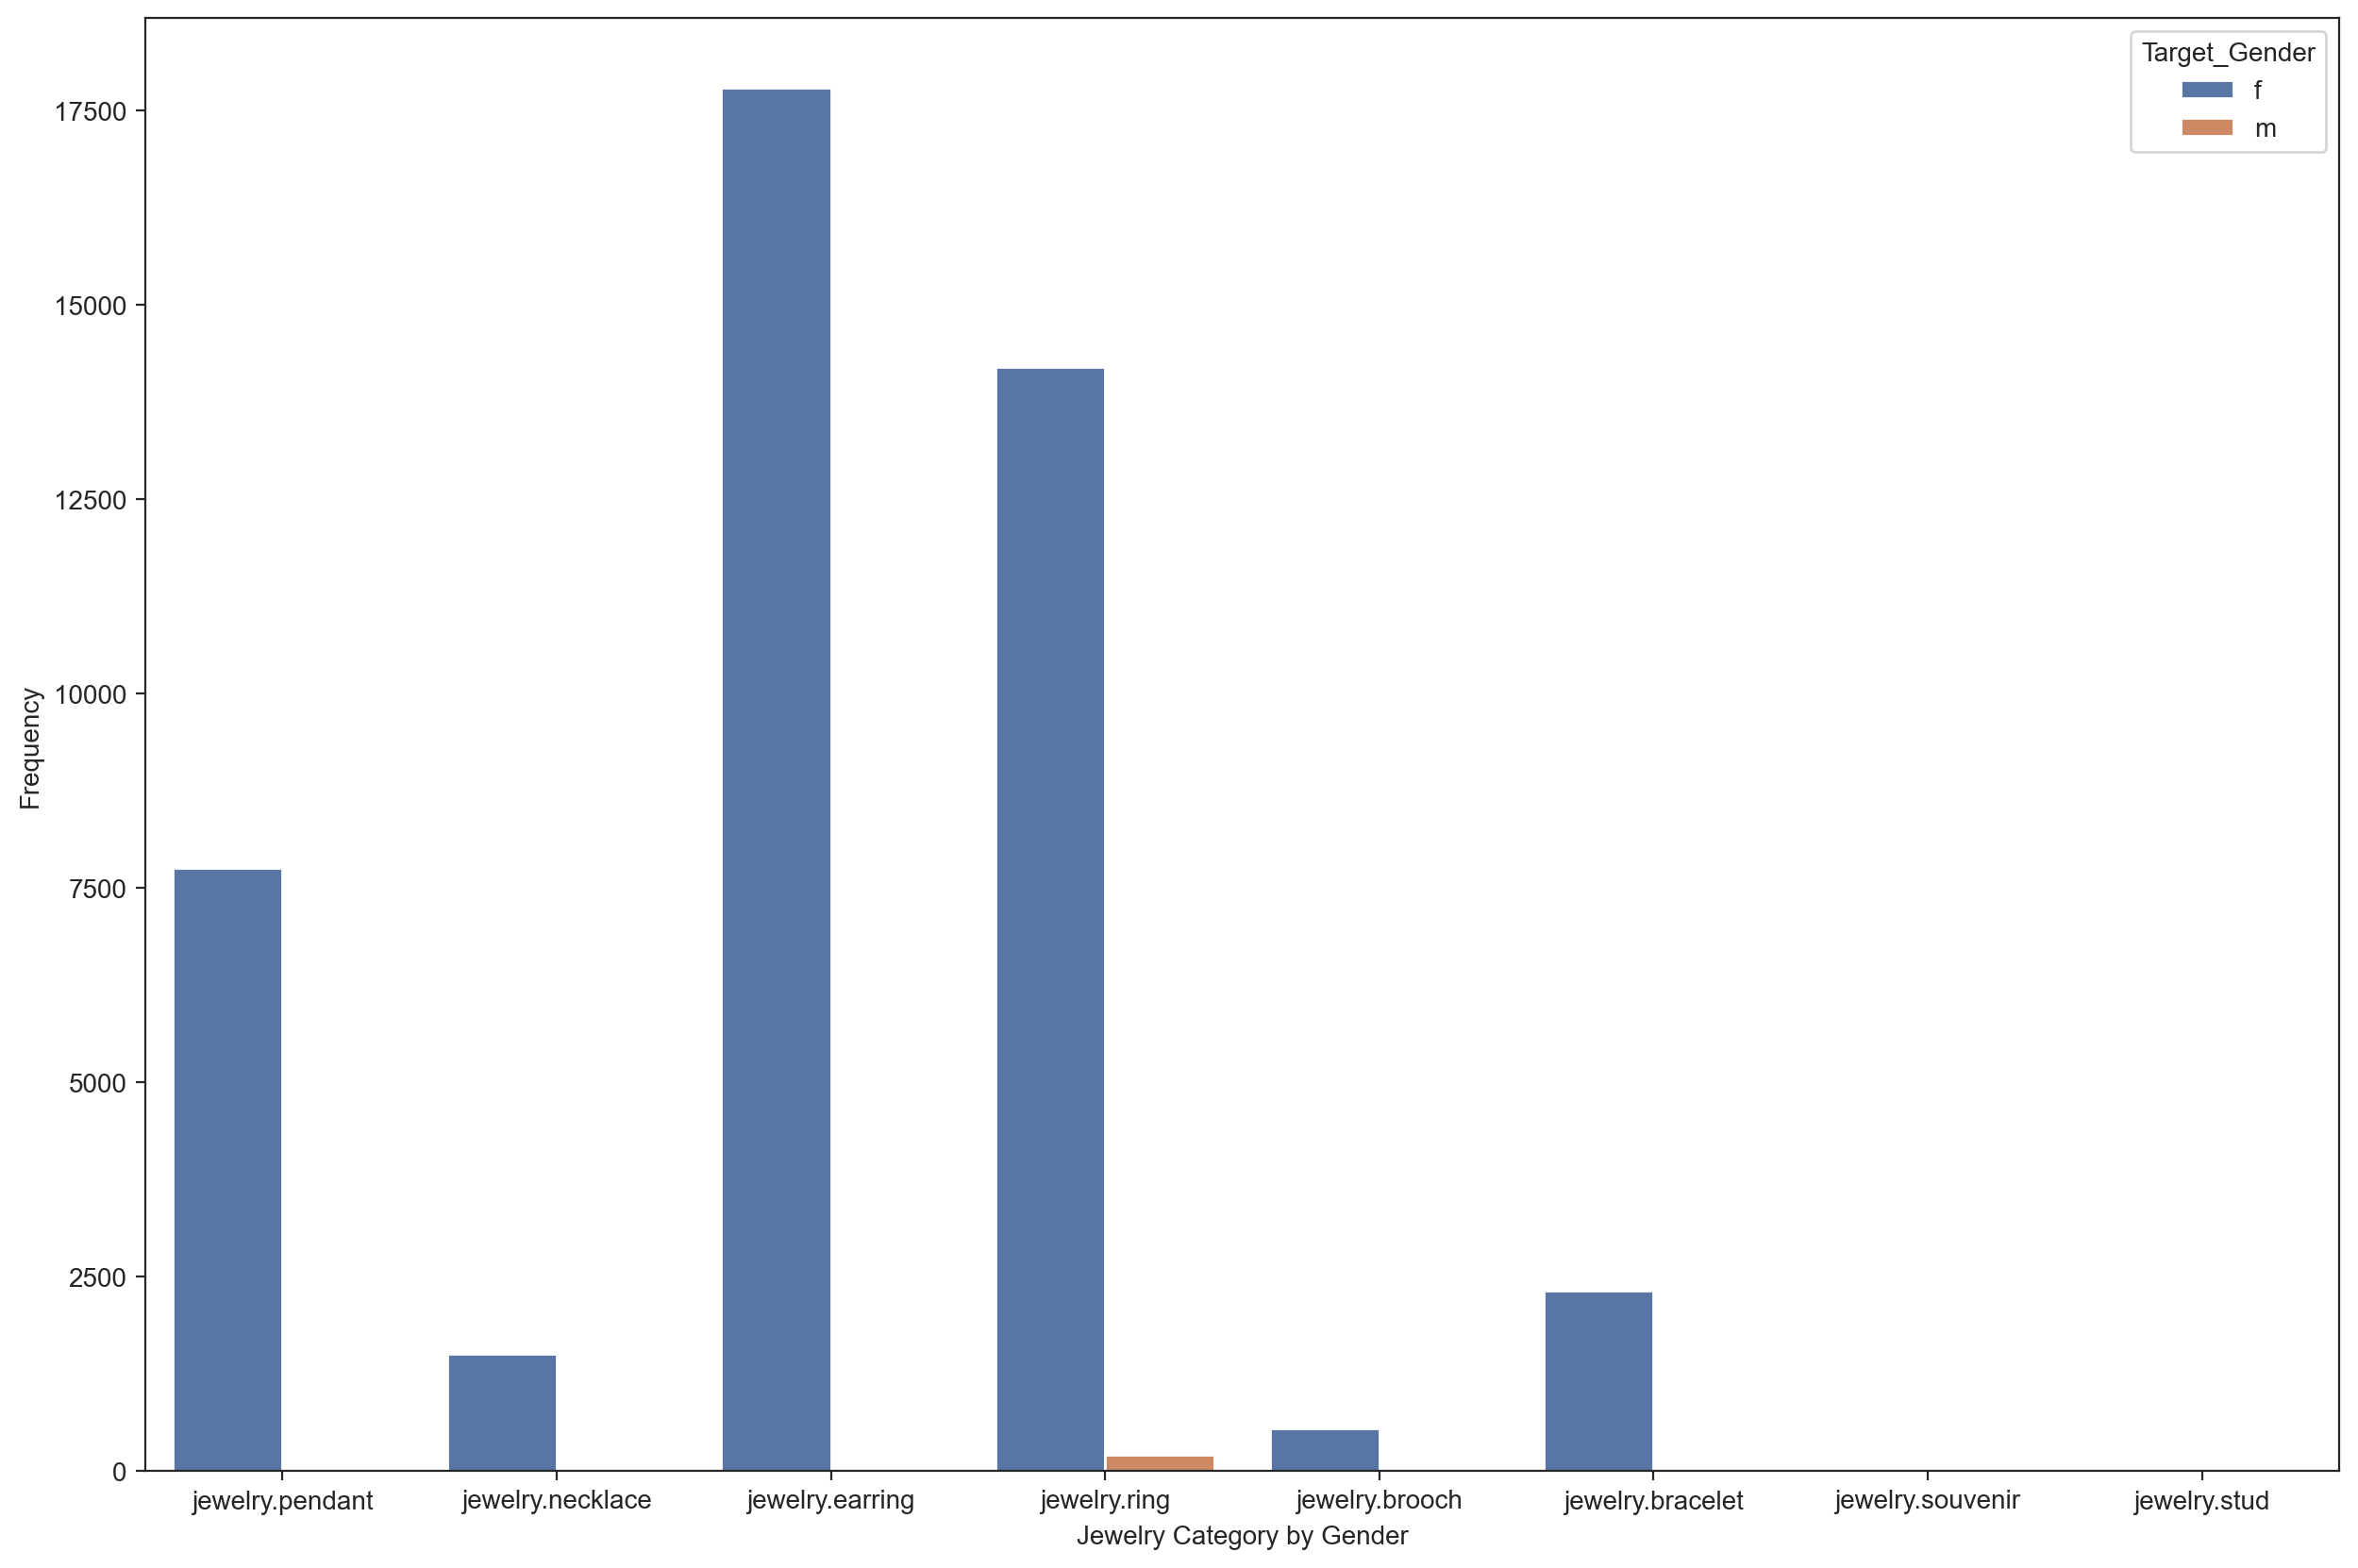

In [12]:
# Jewelry category by gender
plt.figure(figsize=(15,10))

sns.countplot(data = df_cleaned, x = 'Category', hue = 'Target_Gender')

plt.xlabel("Jewelry Category by Gender")
plt.ylabel("Frequency")
plt.show()

# 2.2 Handle Missing Values

In [13]:
def impute_missing_values(data, numerical_features, categorical_features):
    # Impute numerical features with mean
    num_imputer = SimpleImputer(strategy='mean')
    data[numerical_features] = num_imputer.fit_transform(data[numerical_features])
    
    # Impute categorical features with mode
    cat_imputer = SimpleImputer(strategy='most_frequent')
    data[categorical_features] = cat_imputer.fit_transform(data[categorical_features])
    
    return data

# Define feature types
categorical_features = ['Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']
numerical_features = ['Brand_ID']

# Impute missing values
df_cleaned = impute_missing_values(df_cleaned, numerical_features, categorical_features)
print("Missing values handled successfully!")


Missing values handled successfully!


# 2.3 Drop Irrelevant Columns

In [14]:
# Drop unnecessary columns
columns_to_drop = ['Order_datetime', 'Order_ID', 'Product_ID', 'SKU_Quantity', 'Category_ID', 'User_ID']
df_cleaned.drop(columns=columns_to_drop, inplace=True)

# Display the cleaned dataset
df_cleaned.head()


Category  Brand_ID  Price_USD Target_Gender Main_Color Main_Metal  \
0   jewelry.pendant       1.0      54.66             f      white       gold   
1   jewelry.pendant       0.0      88.90             f        red       gold   
2  jewelry.necklace       0.0     417.67             f        red       gold   
3   jewelry.earring       1.0     102.27             f        red       gold   
4   jewelry.earring       0.0     150.55             f        red       gold   

   Main_Gem  
0  sapphire  
1   diamond  
2  amethyst  
3   diamond  
4   diamond

In [15]:
# Check dataset shape
print(f"The Dataset shape is: {df_cleaned.shape}")

print("----------------------------------")

# Checking for missing values in dataset
df_cleaned.isnull().sum()

The Dataset shape is: (80458, 7)
----------------------------------


Category         0
Brand_ID         0
Price_USD        0
Target_Gender    0
Main_Color       0
Main_Metal       0
Main_Gem         0
dtype: int64

# 2.4 Outlier Detection

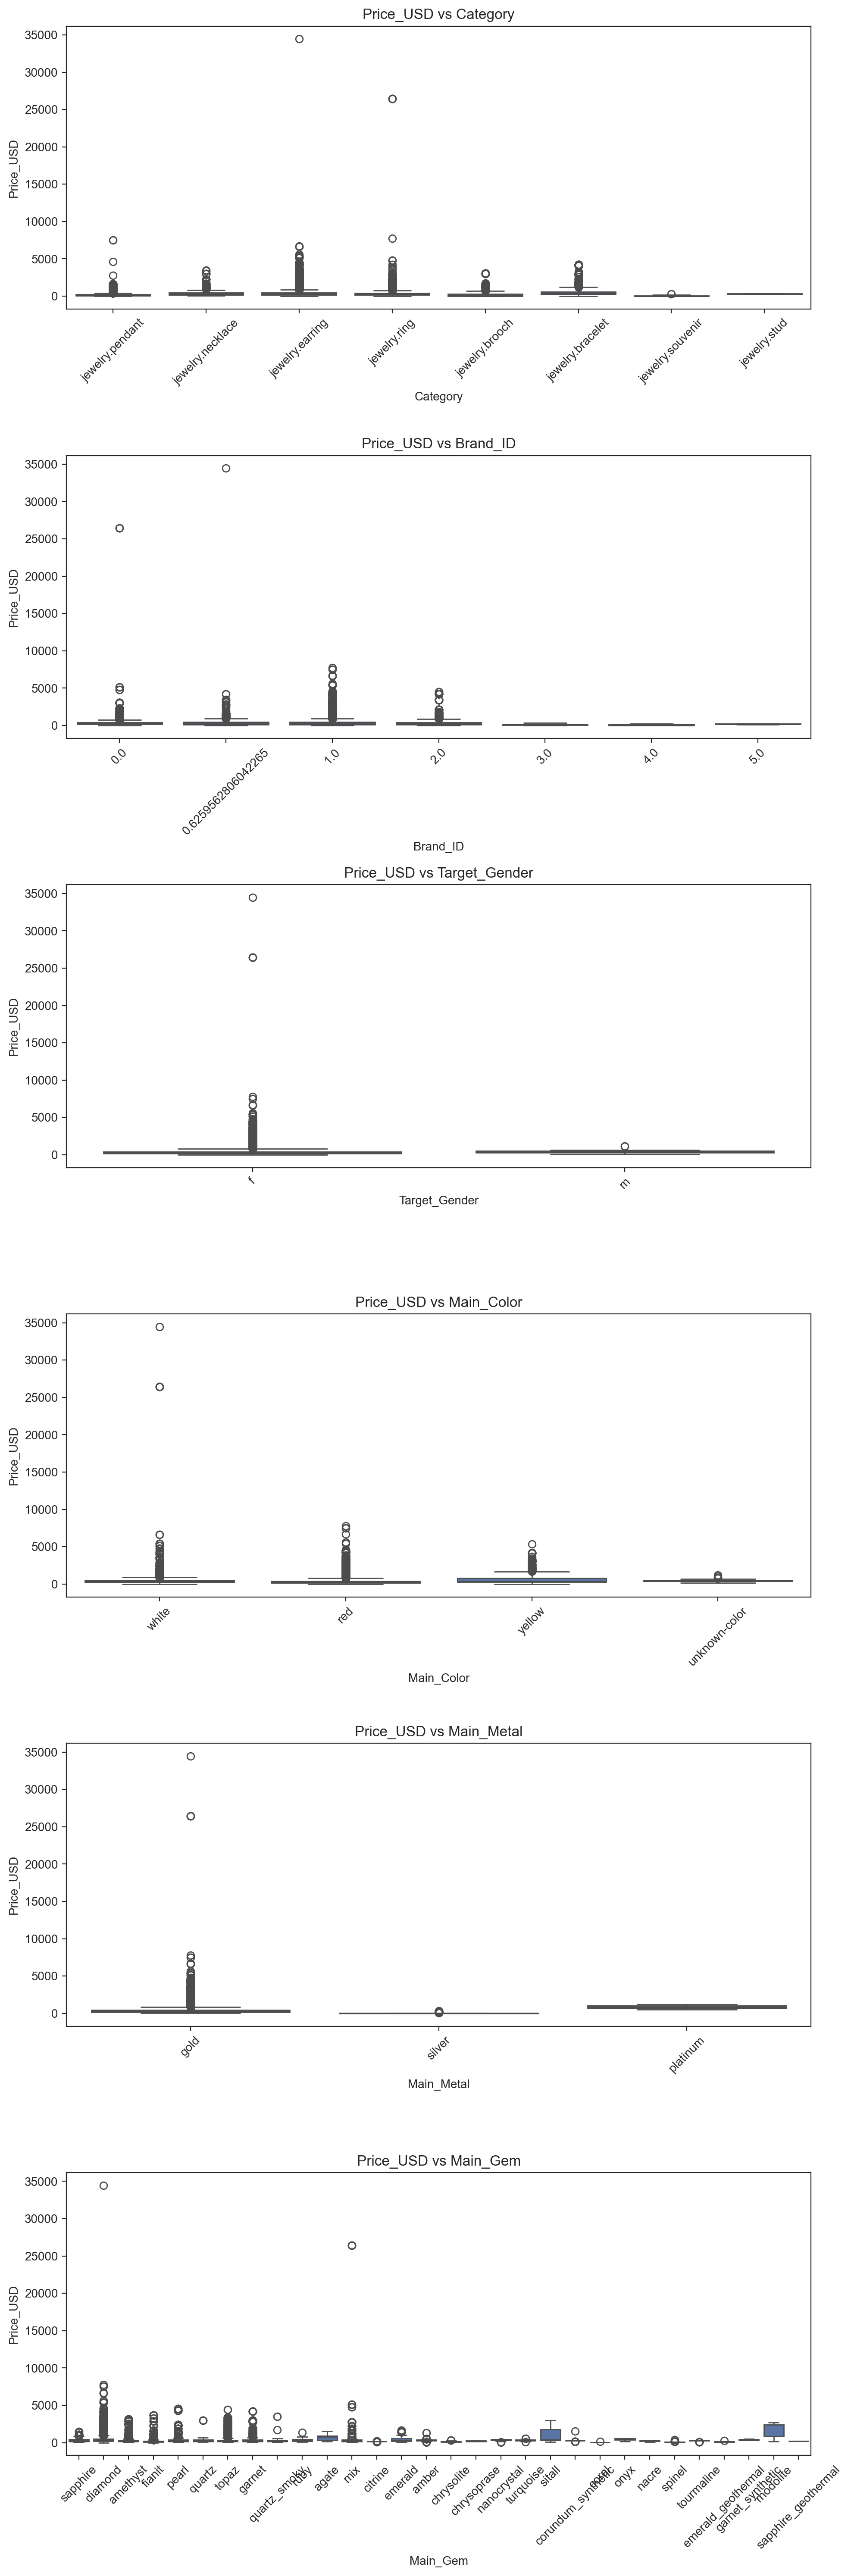

In [16]:
# List of categorical columns
categories = ['Category', 'Brand_ID', 'Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']

# Number of subplots
n = len(categories)

# Create subplots
fig, axes = plt.subplots(n, 1, figsize=(10, 5 * n))

for i, col in enumerate(categories):
    ax = axes[i] if n > 1 else axes  # For single subplot case
    sns.boxplot(data=df_cleaned, x=col, y='Price_USD', ax=ax)
    ax.set_title(f'Price_USD vs {col}')
    ax.set_ylabel('Price_USD')
    ax.set_xlabel(col)
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability if necessary

plt.tight_layout()
plt.show()


# 2.4.1 Outlier Removal

In [17]:
# Fit Isolation Forest on the data
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df_cleaned['Outlier'] = iso_forest.fit_predict(df_cleaned[['Price_USD']])

# Filter out detected outliers
new_df_no_outliers = df_cleaned[df_cleaned['Outlier'] == 1].drop(columns=['Outlier'])

# Rename the cleaned dataset
cleaned_data = new_df_no_outliers

# Display the first few rows of the cleaned data
print(cleaned_data.shape)
cleaned_data.describe()


(79654, 7)


Brand_ID     Price_USD
count  79654.000000  79654.000000
mean       0.622687    326.268973
std        0.675770    269.994335
min        0.000000      0.990000
25%        0.000000    143.700000
50%        0.625956    246.440000
75%        1.000000    410.820000
max        5.000000   1830.140000

# Comment
1.isolation
Since Price_USD likely has a skewed distribution due to the large difference between the mean (352.33) and max (34,448.6), applying a log transformation will reduce the impact of extreme values.



# 3.0 Advanced Correlation Analysis -Phik Correlation Heatmap

Available columns in DataFrame:
Index(['Category', 'Brand_ID', 'Price_USD', 'Target_Gender', 'Main_Color',
       'Main_Metal', 'Main_Gem', 'Outlier'],
      dtype='object')


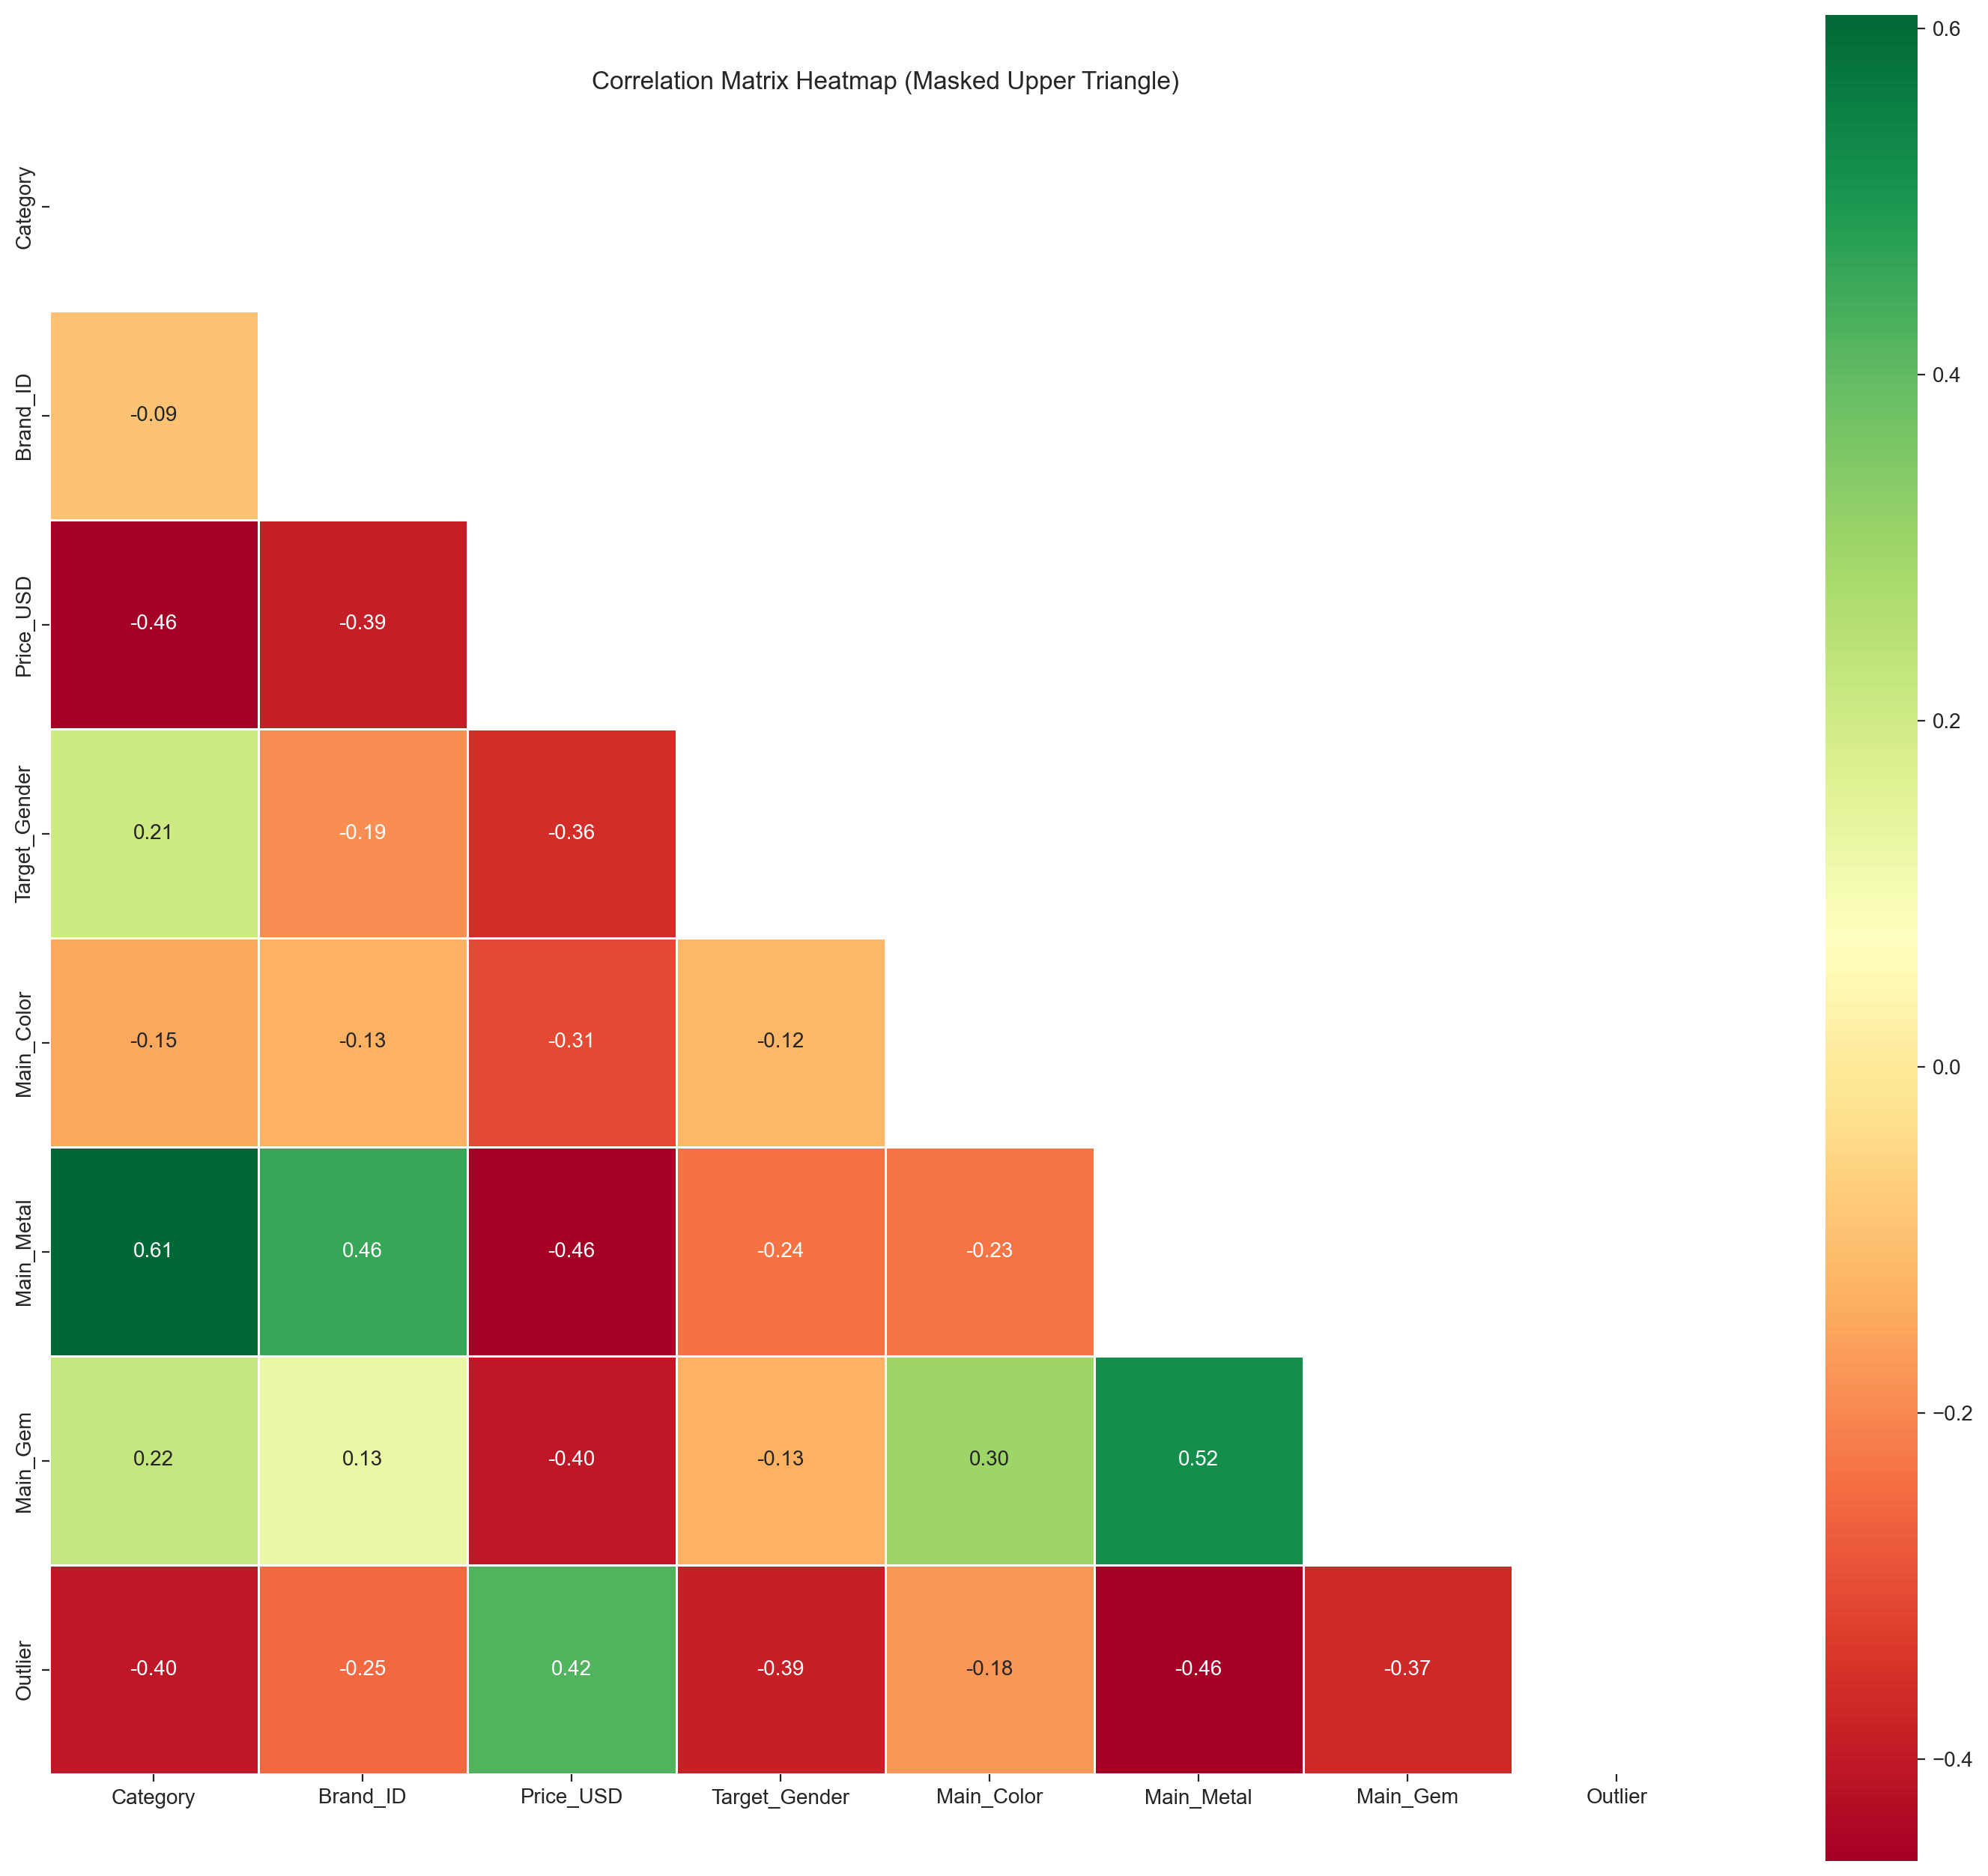

In [18]:
# Convert to DataFrame
df = pd.DataFrame(df_cleaned)

# Display available columns in the DataFrame
print("Available columns in DataFrame:")
print(df.columns)

# Ensure the 'Price_USD' column exists
if 'Price_USD' not in df.columns:
    raise KeyError("'Price_USD' column not found. Please check the correct column name.")

# Select numerical columns for Phik interval calculations
interval_cols = df.select_dtypes(include='number').columns

# Compute Phik matrix
phik_matrix_df = df.phik_matrix(interval_cols=interval_cols)

# # Plot the Phik Matrix Heatmap
# plt.figure(figsize=(14, 12))
# sns.heatmap(phik_matrix_df, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10}, square=True)
# plt.title("Phik Matrix Heatmap")
# plt.show()

# Calculate the correlation matrix from the Phik matrix
corr_matrix = phik_matrix_df.corr()

# Create a mask for the upper triangle using NumPy's triu function
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the heatmap with the mask applied
plt.figure(figsize=(18, 16))
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    square=True, 
    annot=True, 
    cmap='RdYlGn', 
    linewidths=0.5, 
    fmt=".2f", 
    annot_kws={"size": 10}
)
plt.title("Correlation Matrix Heatmap (Masked Upper Triangle)")
plt.show()


#Comment
In summary, PCA highlights that branding, product type, aesthetic features, and gender targeting are crucial factors influencing jewelry pricing. This can guide focused price optimization and marketing strategies.

Final Ranking:
Brand_ID (2.556273) – Most important
Category (2.031020)
Target_Gender (1.958233)
Main_Metal (1.841257)
Main_Color (1.708274)
Main_Gem (1.676945) – Least important
Insights:
Brand_ID dominates, suggesting branding has the greatest impact on pricing.
Category and Target_Gender follow, highlighting the importance of product type and targeted demographics.
Aesthetic features like Main_Metal, Main_Color, and Main_Gem play supporting roles but are less influential overall.

# 4.0 Model Selection, Training, Evaluation and mlflow set-up 

In [20]:
# MLflow Setup
mlflow.set_tracking_uri(uri="http://localhost:5000")
mlflow.set_experiment("Jewelry Price Optimization")

# # MLflow Setup
# mlflow.set_tracking_uri("http://localhost:5000")
# mlflow.set_experiment("Jewelry Price Optimization")

def split_data(df, target_column='Price_USD', test_size=0.3, random_state=42):
    """
    Split the dataset into train and test sets.
    """
    X = cleaned_data.drop(columns=[target_column])
    y = cleaned_data[target_column]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def create_pipeline():
    """
    Create preprocessing pipeline for filling missing values and encoding categorical variables.
    """
    categorical_features = ['Category', 'Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']
    numerical_features = ['Brand_ID']

    # Pipelines for numerical and categorical preprocessing
    cat_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    num_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Combine into a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_pipeline, numerical_features),
            ('cat', cat_pipeline, categorical_features)
        ]
    )
    return preprocessor

def preprocess_data(X_train, X_test, preprocessor):
    """
    Apply preprocessing steps to train and test datasets.
    """
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    return X_train, X_test

def evaluate_model(y_test, preds, model_name):
    """
    Evaluate the model's performance using MAE, MSE, and R².
    """
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae}, MSE: {mse}, R²: {r2}\n")

def tune_hyperparameters(model, param_grid, X_train, y_train):
    """
    Perform grid search with cross-validation for hyperparameter tuning.
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    return grid_search

def log_model_with_mlflow(model, model_name, X_train, y_train):
    """
    Log the model and its metrics using MLflow.
    """
    with mlflow.start_run(run_name=model_name):
        mlflow.log_params(model.best_params_)
        mlflow.log_metric("train_score", model.best_score_)

        # Logging metrics
        preds = model.best_estimator_.predict(X_train)
        mae = mean_absolute_error(y_train, preds)
        mse = mean_squared_error(y_train, preds)
        r2 = r2_score(y_train, preds)

        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("MSE", mse)
        mlflow.log_metric("R2", r2)

        # Log the model itself
        if isinstance(model, GridSearchCV):  # Log best estimator
            mlflow.sklearn.log_model(model.best_estimator_, model_name)

# Main workflow
def main():
    # Assuming 'df_cleaned' is your dataset
   # df_cleaned = pd.read_csv("your_dataset.csv")  # Replace with your actual dataset
    X_train, X_test, y_train, y_test = split_data(cleaned_data)

    # Create and apply preprocessing pipeline
    preprocessor = create_pipeline()
    X_train, X_test = preprocess_data(X_train, X_test, preprocessor)

    # Hyperparameter grids for all models
    rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}
    xgb_params = {'learning_rate': [0.05, 0.1], 'max_depth': [5, 7], 'n_estimators': [100, 200]}
    gbr_params = {'learning_rate': [0.05, 0.1], 'n_estimators': [100, 200], 'max_depth': [3, 5]}
    lgbm_params = {'num_leaves': [31, 50], 'learning_rate': [0.05, 0.1], 'n_estimators': [100, 200]}
    #cat_params = {'depth': [6, 8], 'learning_rate': [0.05, 0.1], 'iterations': [200, 300]}




    # Initialize models
    models = [
        (RandomForestRegressor(random_state=42), rf_params, "Random Forest"),
        (XGBRegressor(random_state=42), xgb_params, "XGBoost"),
        (GradientBoostingRegressor(random_state=42), gbr_params, "Gradient Boosting"),
        (LGBMRegressor(random_state=42), lgbm_params, "LightGBM"),
        #(CatBoostRegressor(random_state=42, verbose=0), cat_params, "CatBoost")
    ]

    # Tune, evaluate, and log models
    for model, params, name in models:
        print(f"Tuning {name}...")
        tuned_model = tune_hyperparameters(model, params, X_train, y_train)
        preds = tuned_model.best_estimator_.predict(X_test)
        evaluate_model(y_test, preds, name)
        log_model_with_mlflow(tuned_model, name, X_train, y_train)

# Run the pipeline
if __name__ == "__main__":
    main()


Tuning Random Forest...
Best parameters for RandomForestRegressor: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Performance:
MAE: 151.94856122630787, MSE: 51804.911852428275, R²: 0.30010459359565034



2024/11/28 19:39:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://localhost:5000/#/experiments/1/runs/43b05e2533af4a9199a4c50937914ae3
🧪 View experiment at: http://localhost:5000/#/experiments/1
Tuning XGBoost...
Best parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
XGBoost Performance:
MAE: 152.2629184482594, MSE: 51852.19706651743, R²: 0.29946576026984284



2024/11/28 19:39:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: http://localhost:5000/#/experiments/1/runs/f03afd2aacba43f3998afe139e8c3924
🧪 View experiment at: http://localhost:5000/#/experiments/1
Tuning Gradient Boosting...
Best parameters for GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Gradient Boosting Performance:
MAE: 153.85962827760795, MSE: 52566.190245855534, R²: 0.28981956015958543



2024/11/28 19:40:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Gradient Boosting at: http://localhost:5000/#/experiments/1/runs/93a8c3f526a141e699cb94ce510fcb67
🧪 View experiment at: http://localhost:5000/#/experiments/1
Tuning LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 55757, number of used features: 38
[LightGBM] [Info] Start training from score 325.352342
Best parameters for LGBMRegressor: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 50}
LightGBM Performance:
MAE: 152.7873550988366, MSE: 52087.91136433092, R²: 0.29628120984085204



2024/11/28 19:40:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM at: http://localhost:5000/#/experiments/1/runs/6abfda1540cf4a85b370698c3118530d
🧪 View experiment at: http://localhost:5000/#/experiments/1


Tuning Random Forest...
Best parameters for RandomForestRegressor: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Performance:
MAE: 151.94856122630787, MSE: 51804.911852428275, R²: 0.30010459359565034

Random Forest Performance:
MAE: 149.3313666341641, MSE: 51037.00327615932, R²: 0.29518898377789393



2024/11/28 20:27:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://localhost:5000/#/experiments/1/runs/ebb735e5e1684f138982c63aeb80e36c
🧪 View experiment at: http://localhost:5000/#/experiments/1
Tuning XGBoost...
Best parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
XGBoost Performance:
MAE: 152.2629184482594, MSE: 51852.19706651743, R²: 0.29946576026984284

XGBoost Performance:
MAE: 149.62430552369221, MSE: 51097.06070446645, R²: 0.2943596024592495



2024/11/28 20:27:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: http://localhost:5000/#/experiments/1/runs/56e90d34a3af4be2b0714c1d3ed34128
🧪 View experiment at: http://localhost:5000/#/experiments/1
Tuning Gradient Boosting...
Best parameters for GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Gradient Boosting Performance:
MAE: 153.85962827760795, MSE: 52566.190245855534, R²: 0.28981956015958543

Gradient Boosting Performance:
MAE: 151.0171752785353, MSE: 51678.106351656024, R²: 0.2863354759083394



2024/11/28 20:28:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Gradient Boosting at: http://localhost:5000/#/experiments/1/runs/d45de93c91f24fc68f26233e41d4ca6c
🧪 View experiment at: http://localhost:5000/#/experiments/1
Tuning LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 55757, number of used features: 38
[LightGBM] [Info] Start training from score 325.352342
Best parameters for LGBMRegressor: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 50}
LightGBM Performance:
MAE: 152.7873550988366, MSE: 52087.91136433092, R²: 0.29628120984085204

LightGBM Performance:
MAE: 150.2716036664569, MSE: 51367.1932936543, R²: 0.29062912432615884



2024/11/28 20:29:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM at: http://localhost:5000/#/experiments/1/runs/bbf53ff6a2284a0b950a311b1e7691b8
🧪 View experiment at: http://localhost:5000/#/experiments/1


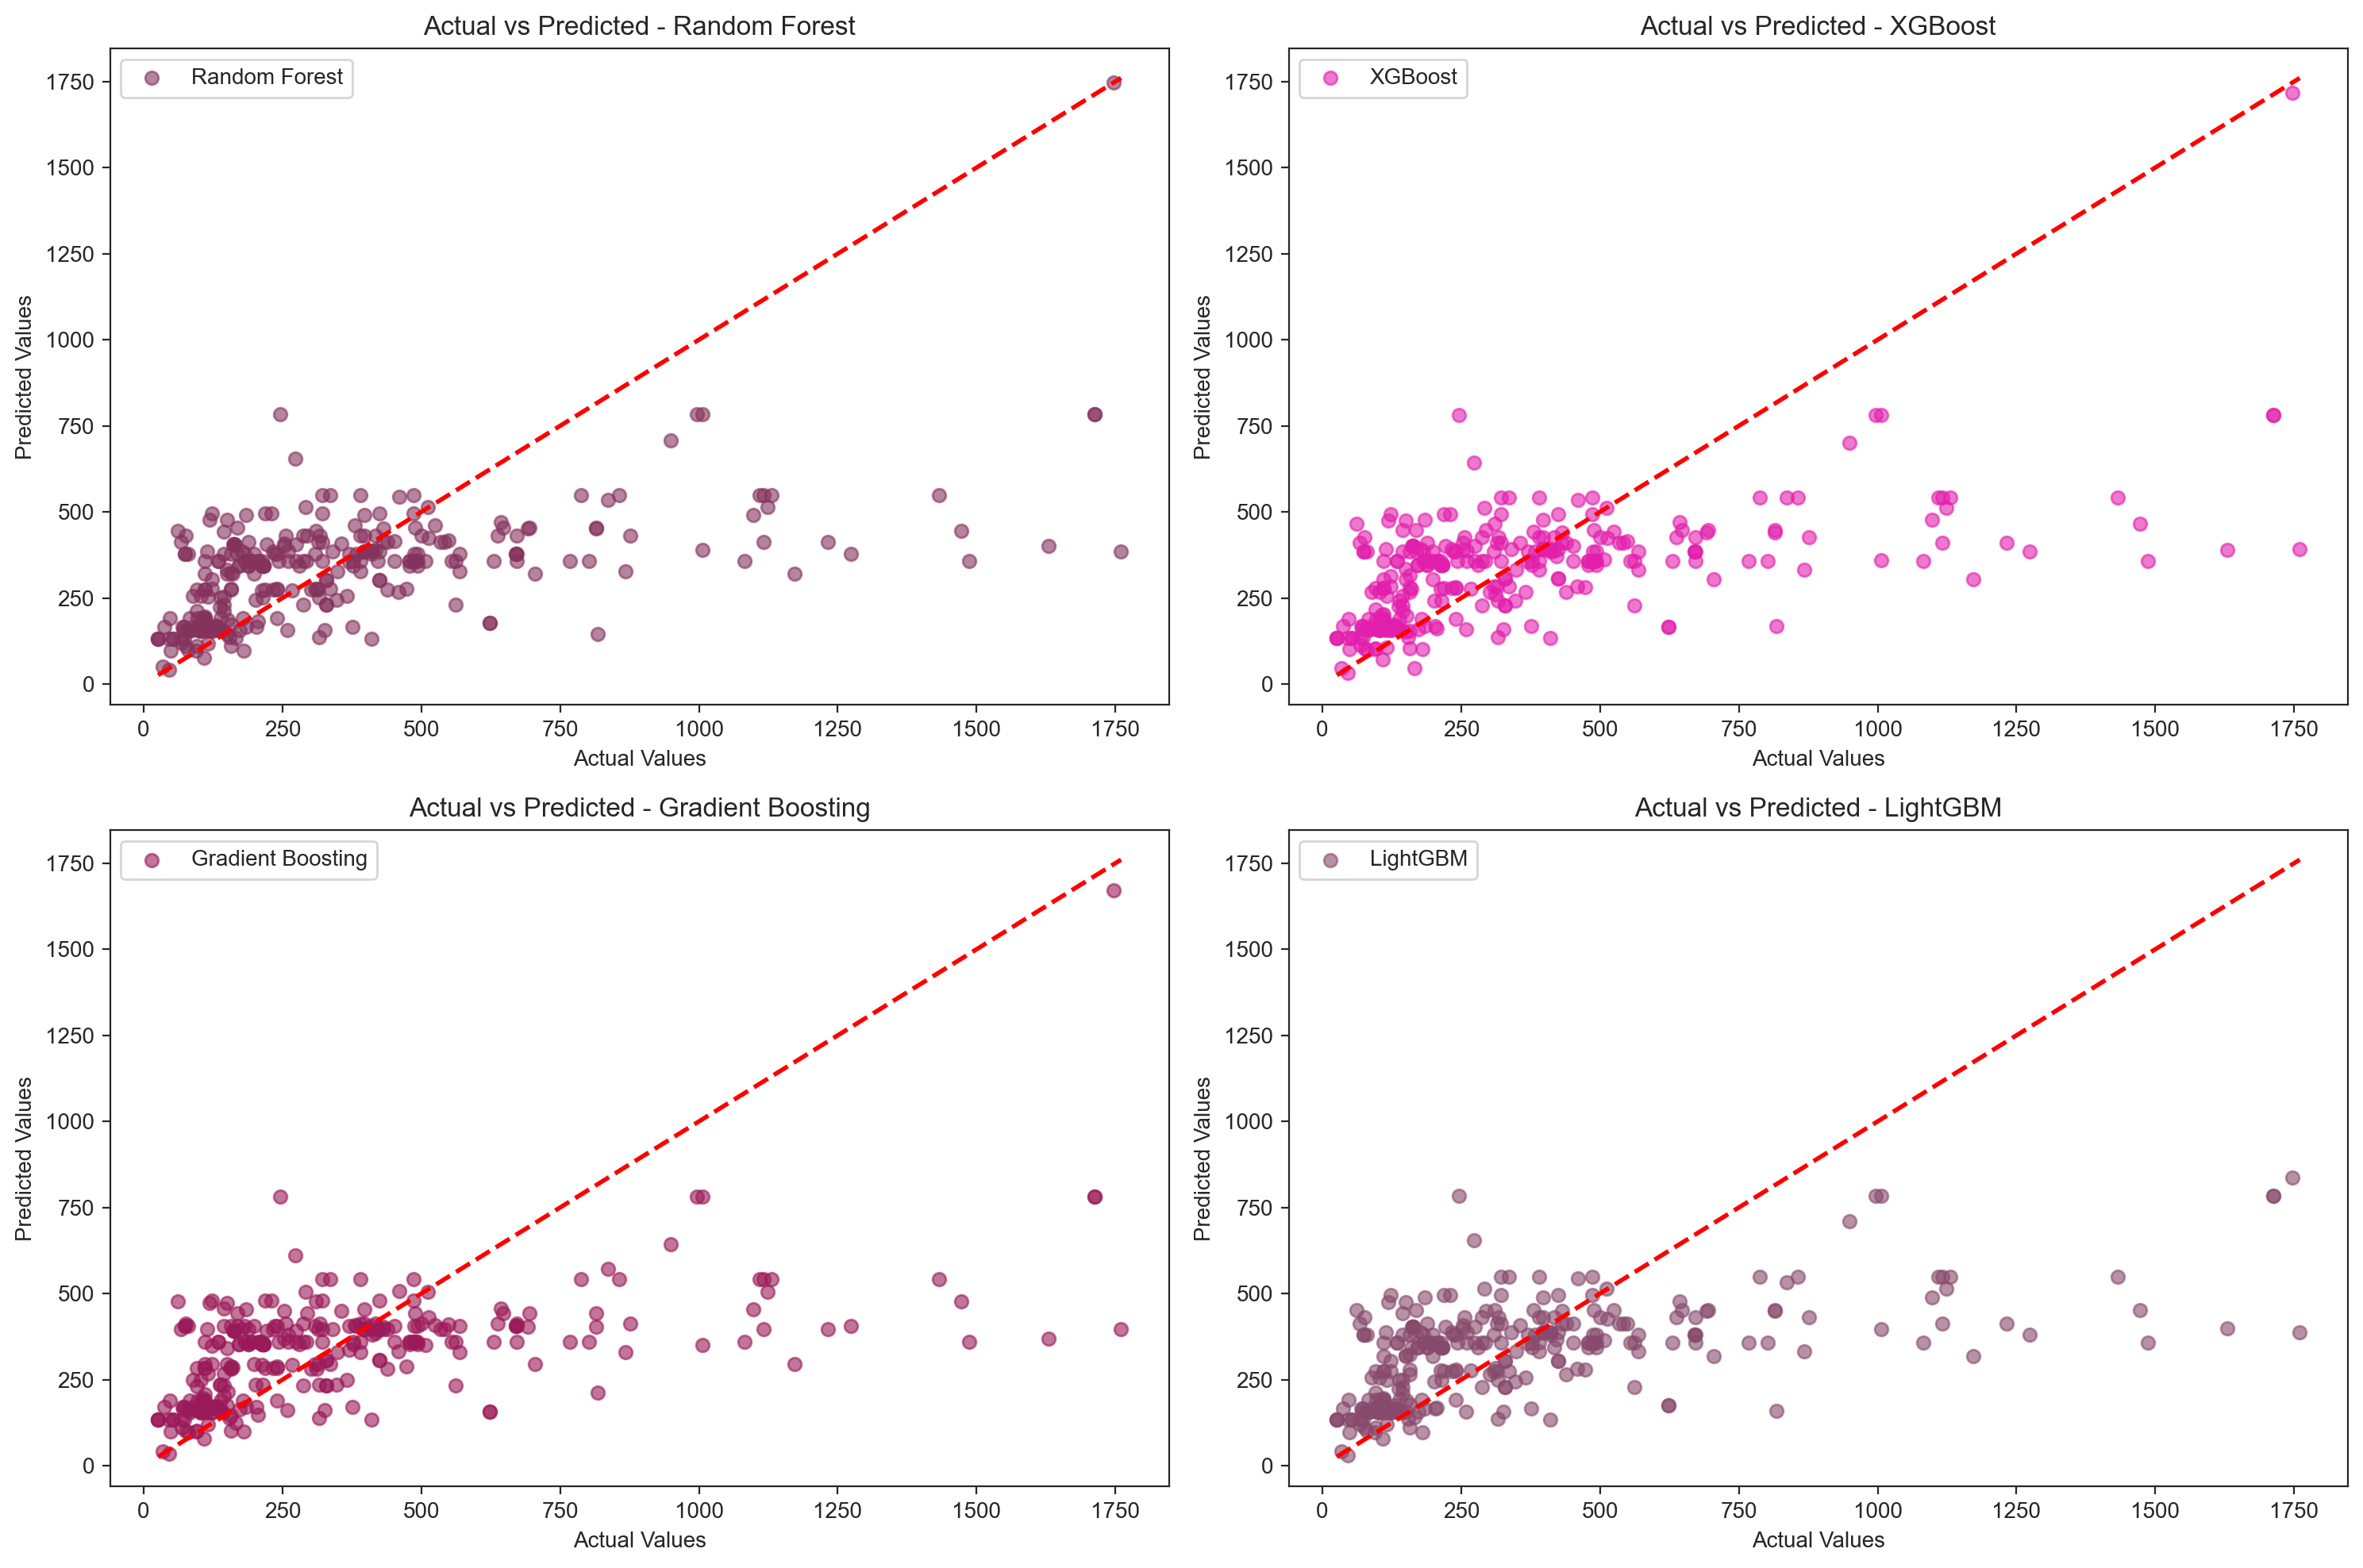

Comparison DataFrame (First 5 Instances):
       Actual Values  Random Forest Predicted  Random Forest Difference  \
36672         162.88               405.058420                242.178420   
54094          95.75               110.179029                 14.429029   
7483           71.10               156.035855                 84.935855   
11061        1109.45               548.245597                561.204403   
39684         188.70               342.699083                153.999083   

       XGBoost Predicted  XGBoost Difference  Gradient Boosting Predicted  \
36672         400.978363          238.098363                   392.764792   
54094         104.134453            8.384453                   101.786042   
7483          159.440903           88.340903                   164.224057   
11061         542.507507          566.942493                   541.733493   
39684         344.748383          156.048383                   352.658867   

       Gradient Boosting Difference  LightGB

In [28]:
# import mlflow
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from sklearn.model_selection import train_test_split, GridSearchCV, KFold
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.impute import SimpleImputer
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# MLflow Setup
mlflow.set_tracking_uri(uri="http://localhost:5000")
mlflow.set_experiment("Jewelry Price Optimization")

def split_data(df, target_column='Price_USD', test_size=0.3, random_state=42):
    """
    Split the dataset into train and test sets.
    """
    X = df.drop(columns=[target_column])
    y = df[target_column]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def create_pipeline():
    """
    Create preprocessing pipeline for filling missing values and encoding categorical variables.
    """
    categorical_features = ['Category', 'Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']
    numerical_features = ['Brand_ID']

    # Pipelines for numerical and categorical preprocessing
    cat_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    num_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Combine into a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_pipeline, numerical_features),
            ('cat', cat_pipeline, categorical_features)
        ]
    )
    return preprocessor

def preprocess_data(X_train, X_test, preprocessor):
    """
    Apply preprocessing steps to train and test datasets.
    """
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    return X_train, X_test

def evaluate_model(y_test, preds, model_name):
    """
    Evaluate the model's performance using MAE, MSE, and R².
    """
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae}, MSE: {mse}, R²: {r2}\n")
    return mae, mse, r2

def tune_hyperparameters(model, param_grid, X_train, y_train):
    """
    Perform grid search with cross-validation for hyperparameter tuning.
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    return grid_search

def log_model_with_mlflow(model, model_name, X_train, y_train):
    """
    Log the model and its metrics using MLflow.
    """
    with mlflow.start_run(run_name=model_name):
        mlflow.log_params(model.best_params_)
        mlflow.log_metric("train_score", model.best_score_)

        # Logging metrics
        preds = model.best_estimator_.predict(X_train)
        mae, mse, r2 = evaluate_model(y_train, preds, model_name)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("MSE", mse)
        mlflow.log_metric("R2", r2)

        # Log the model itself
        mlflow.sklearn.log_model(model.best_estimator_, model_name)

def plot_actual_vs_predicted(y_test, preds_dict, num_instances=300):
    """
    Plot Actual vs Predicted values for all models.
    """
    y_test_subset = y_test[:num_instances]
    plt.figure(figsize=(15, 10))
    for i, (model_name, preds) in enumerate(preds_dict.items(), 1):
        preds_subset = preds[:num_instances]
        plt.subplot(2, 2, i)
        plt.scatter(y_test_subset, preds_subset, alpha=0.6, label=model_name, color=np.random.rand(3,))
        plt.plot([y_test_subset.min(), y_test_subset.max()], [y_test_subset.min(), y_test_subset.max()], color='red', lw=2, linestyle='--')
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title(f"Actual vs Predicted - {model_name}")
        plt.legend()
    plt.tight_layout()
    plt.show()

def compare_predictions(y_test, preds_dict, num_instances=5):
    """
    Create a DataFrame to compare actual vs predicted values for the first few instances.
    """
    comparison_data = {"Actual Values": y_test[:num_instances].values}
    for model_name, preds in preds_dict.items():
        comparison_data[f"{model_name} Predicted"] = preds[:num_instances]
        comparison_data[f"{model_name} Difference"] = abs(y_test[:num_instances] - preds[:num_instances])
    comparison_df = pd.DataFrame(comparison_data)
    print("Comparison DataFrame (First 5 Instances):")
    print(comparison_df)
    return comparison_df

# Main workflow
def main():
    # Assuming 'cleaned_data' is your dataset
    X_train, X_test, y_train, y_test = split_data(cleaned_data)

    # Create and apply preprocessing pipeline
    preprocessor = create_pipeline()
    X_train, X_test = preprocess_data(X_train, X_test, preprocessor)

    # Hyperparameter grids for all models
    rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}
    xgb_params = {'learning_rate': [0.05, 0.1], 'max_depth': [5, 7], 'n_estimators': [100, 200]}
    gbr_params = {'learning_rate': [0.05, 0.1], 'n_estimators': [100, 200], 'max_depth': [3, 5]}
    lgbm_params = {'num_leaves': [31, 50], 'learning_rate': [0.05, 0.1], 'n_estimators': [100, 200]}

    # Initialize models
    models = [
        (RandomForestRegressor(random_state=42), rf_params, "Random Forest"),
        (XGBRegressor(random_state=42), xgb_params, "XGBoost"),
        (GradientBoostingRegressor(random_state=42), gbr_params, "Gradient Boosting"),
        (LGBMRegressor(random_state=42), lgbm_params, "LightGBM")
    ]

    preds_dict = {}
    # Tune, evaluate, log, and collect predictions
    for model, params, name in models:
        print(f"Tuning {name}...")
        tuned_model = tune_hyperparameters(model, params, X_train, y_train)
        preds = tuned_model.best_estimator_.predict(X_test)
        preds_dict[name] = preds
        evaluate_model(y_test, preds, name)
        log_model_with_mlflow(tuned_model, name, X_train, y_train)

    # Plot Actual vs Predicted
    plot_actual_vs_predicted(y_test, preds_dict)

    # Compare predictions
    compare_predictions(y_test, preds_dict)

# Run the pipeline
if __name__ == "__main__":
    main()


# 4.1 Model Evaluation Comparison

In [29]:
# Model results
model_names = ['Random Forest', 'XGBoost', 'Gradient Boosting', 'LightGBM']
mae = [151.95, 152.26, 153.86, 152.79]
mse = [51804.91, 51852.20, 52566.19, 52087.91]
r2 = [0.300, 0.299, 0.290, 0.296]

# Create a dictionary for the results
results_dict = {
    'Model': model_names,
    'MAE (USD)': mae,
    'MSE (USD²)': mse,
    'R² Score': r2
}

# Create a DataFrame
results_df = pd.DataFrame(results_dict)

# Display the results
results_df


Model  MAE (USD)  MSE (USD²)  R² Score
0      Random Forest     151.95    51804.91     0.300
1            XGBoost     152.26    51852.20     0.299
2  Gradient Boosting     153.86    52566.19     0.290
3           LightGBM     152.79    52087.91     0.296

# 4.2 ACTUAL VS PREDICTED ANALYSIS

################################